In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import copy
import time
import numpy as np
sys.path.append(os.path.join(os.path.abspath(""), ".."))

import matplotlib.pyplot as plt

In [3]:
from app.utils import ImageWrapper
from app.custom import RemoveBusBars, Orient
from app.transforms import FFT, IFFT, CreateOnesMask, PCA
from app.filters import CreateKernel, Convolve, Canny, HOG, Threshold_Multiotsu
from app.imager import ImageLoader, DefectViewer, Show, Exposure

In [4]:
# Seed used in show to show the same images when num_images option is set
seed = 1234

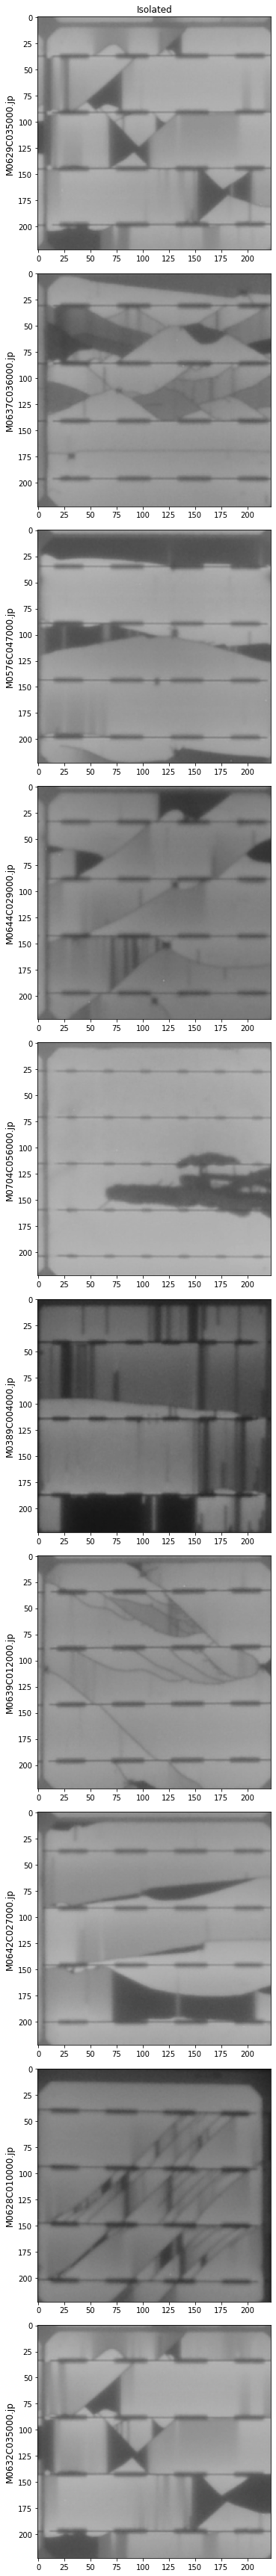

In [6]:
# Load 100 examples and name the category for it. Category is like a title for images
n_samples = 10
isolated = (DefectViewer() << (ImageLoader(defect_class='Isolated') << n_samples))
isolated.category = 'Isolated'
_ = Show(num_images=10, seed=seed) << (isolated)

## EDA 
Isolated Cracks have the following defining features:

- They are darker regions (areas of low luminesence) compared to the rest of the cell, and are often 'dead', which present as black in these images. 
- They are often irregular in shape, but they can be rectangular in shape. 
- They occur typically in the presence of other cracks. 

Potential Approach
- Inverting the image so that the dark regions are brigher regions (not neccesary but just more intuitive when 'subtracting' information we don't want). 
- Thresholding to keep only the brightest (previously darker) regions.
- Potential filtering of vertical lines, so the model doesn't confuse dark vertical fingers
- Potential filtering of horizontal lines, so the model doesn't the busbars. 
- Application of a blob detector to highlight the blobs.
- Erode the background


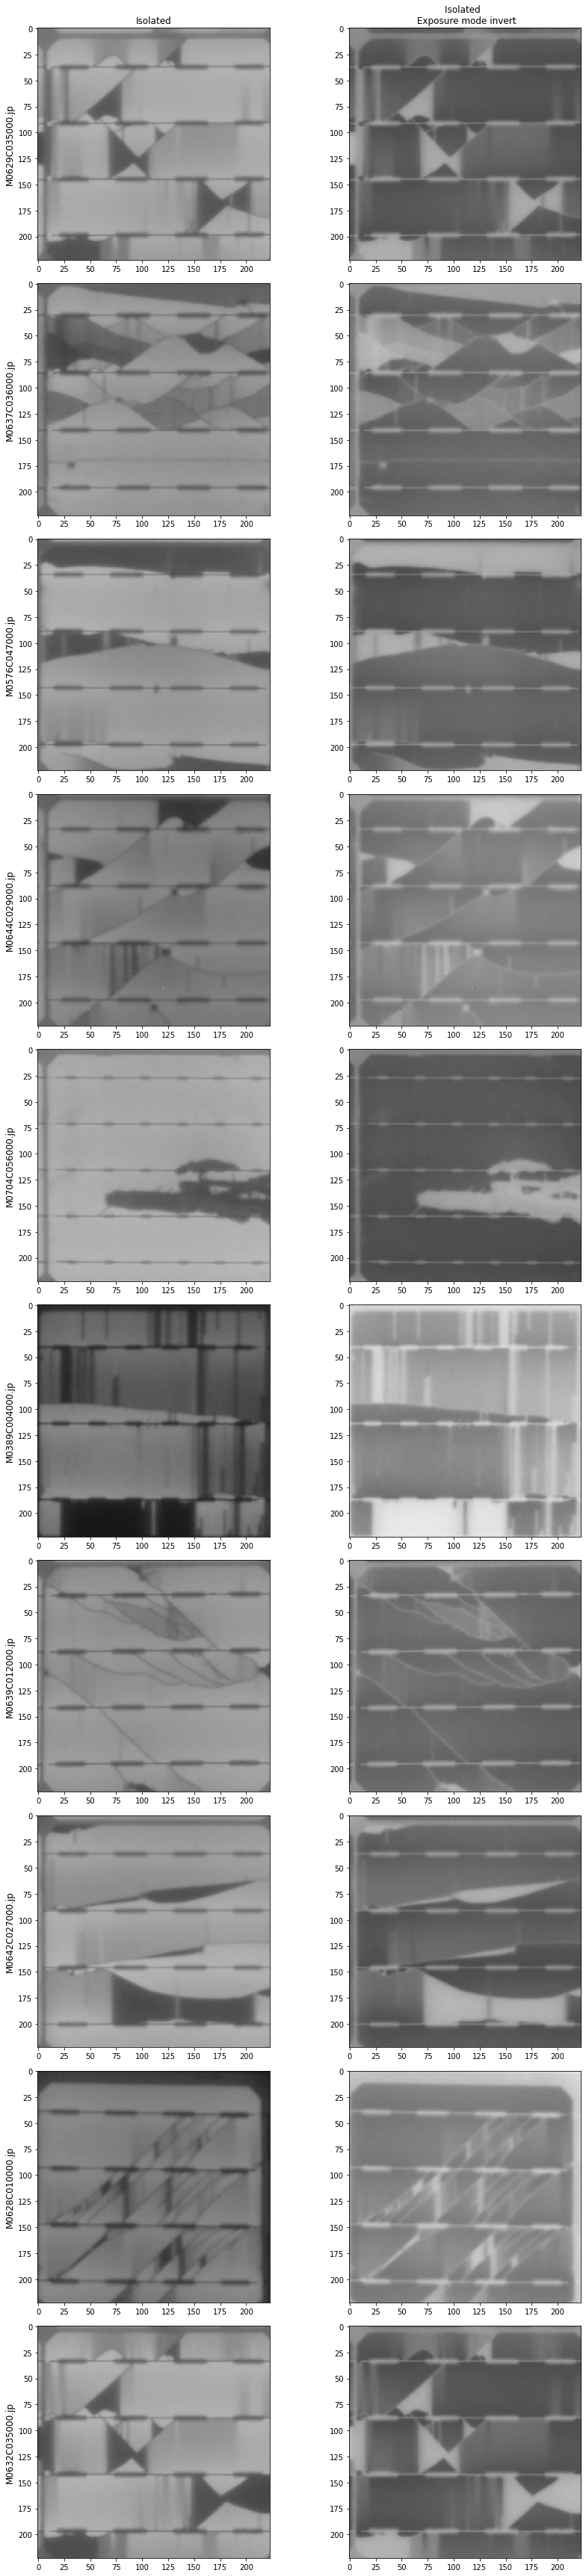

In [7]:
## INVERT IMAGES ## 
# Invert images
original, inverted = Exposure('invert') << isolated
_ = Show(num_images=10, seed=seed) << (original, inverted)

Next we apply thresholding the images using Multi-Otsu thresholding, which is a method of finding threshold boundaries which maximises the inter-bin variances. Because of this, we can apply a local threshold for each image, rather than a global value for all images. This is particularly useful because the incoming images are not normalised/scaled to a global value - a bright region on a bad cell may actually in absolute intensity correspond to a poor region on a good cell. 

In [16]:
## Apply multi-otsu thresholding, we experiment with 2 and 3 thresholds. 
_, thresholded_2 = (Threshold_Multiotsu(2) << (Exposure('invert') << isolated))
_, thresholded_3 = (Threshold_Multiotsu(3) << (Exposure('invert') << isolated))

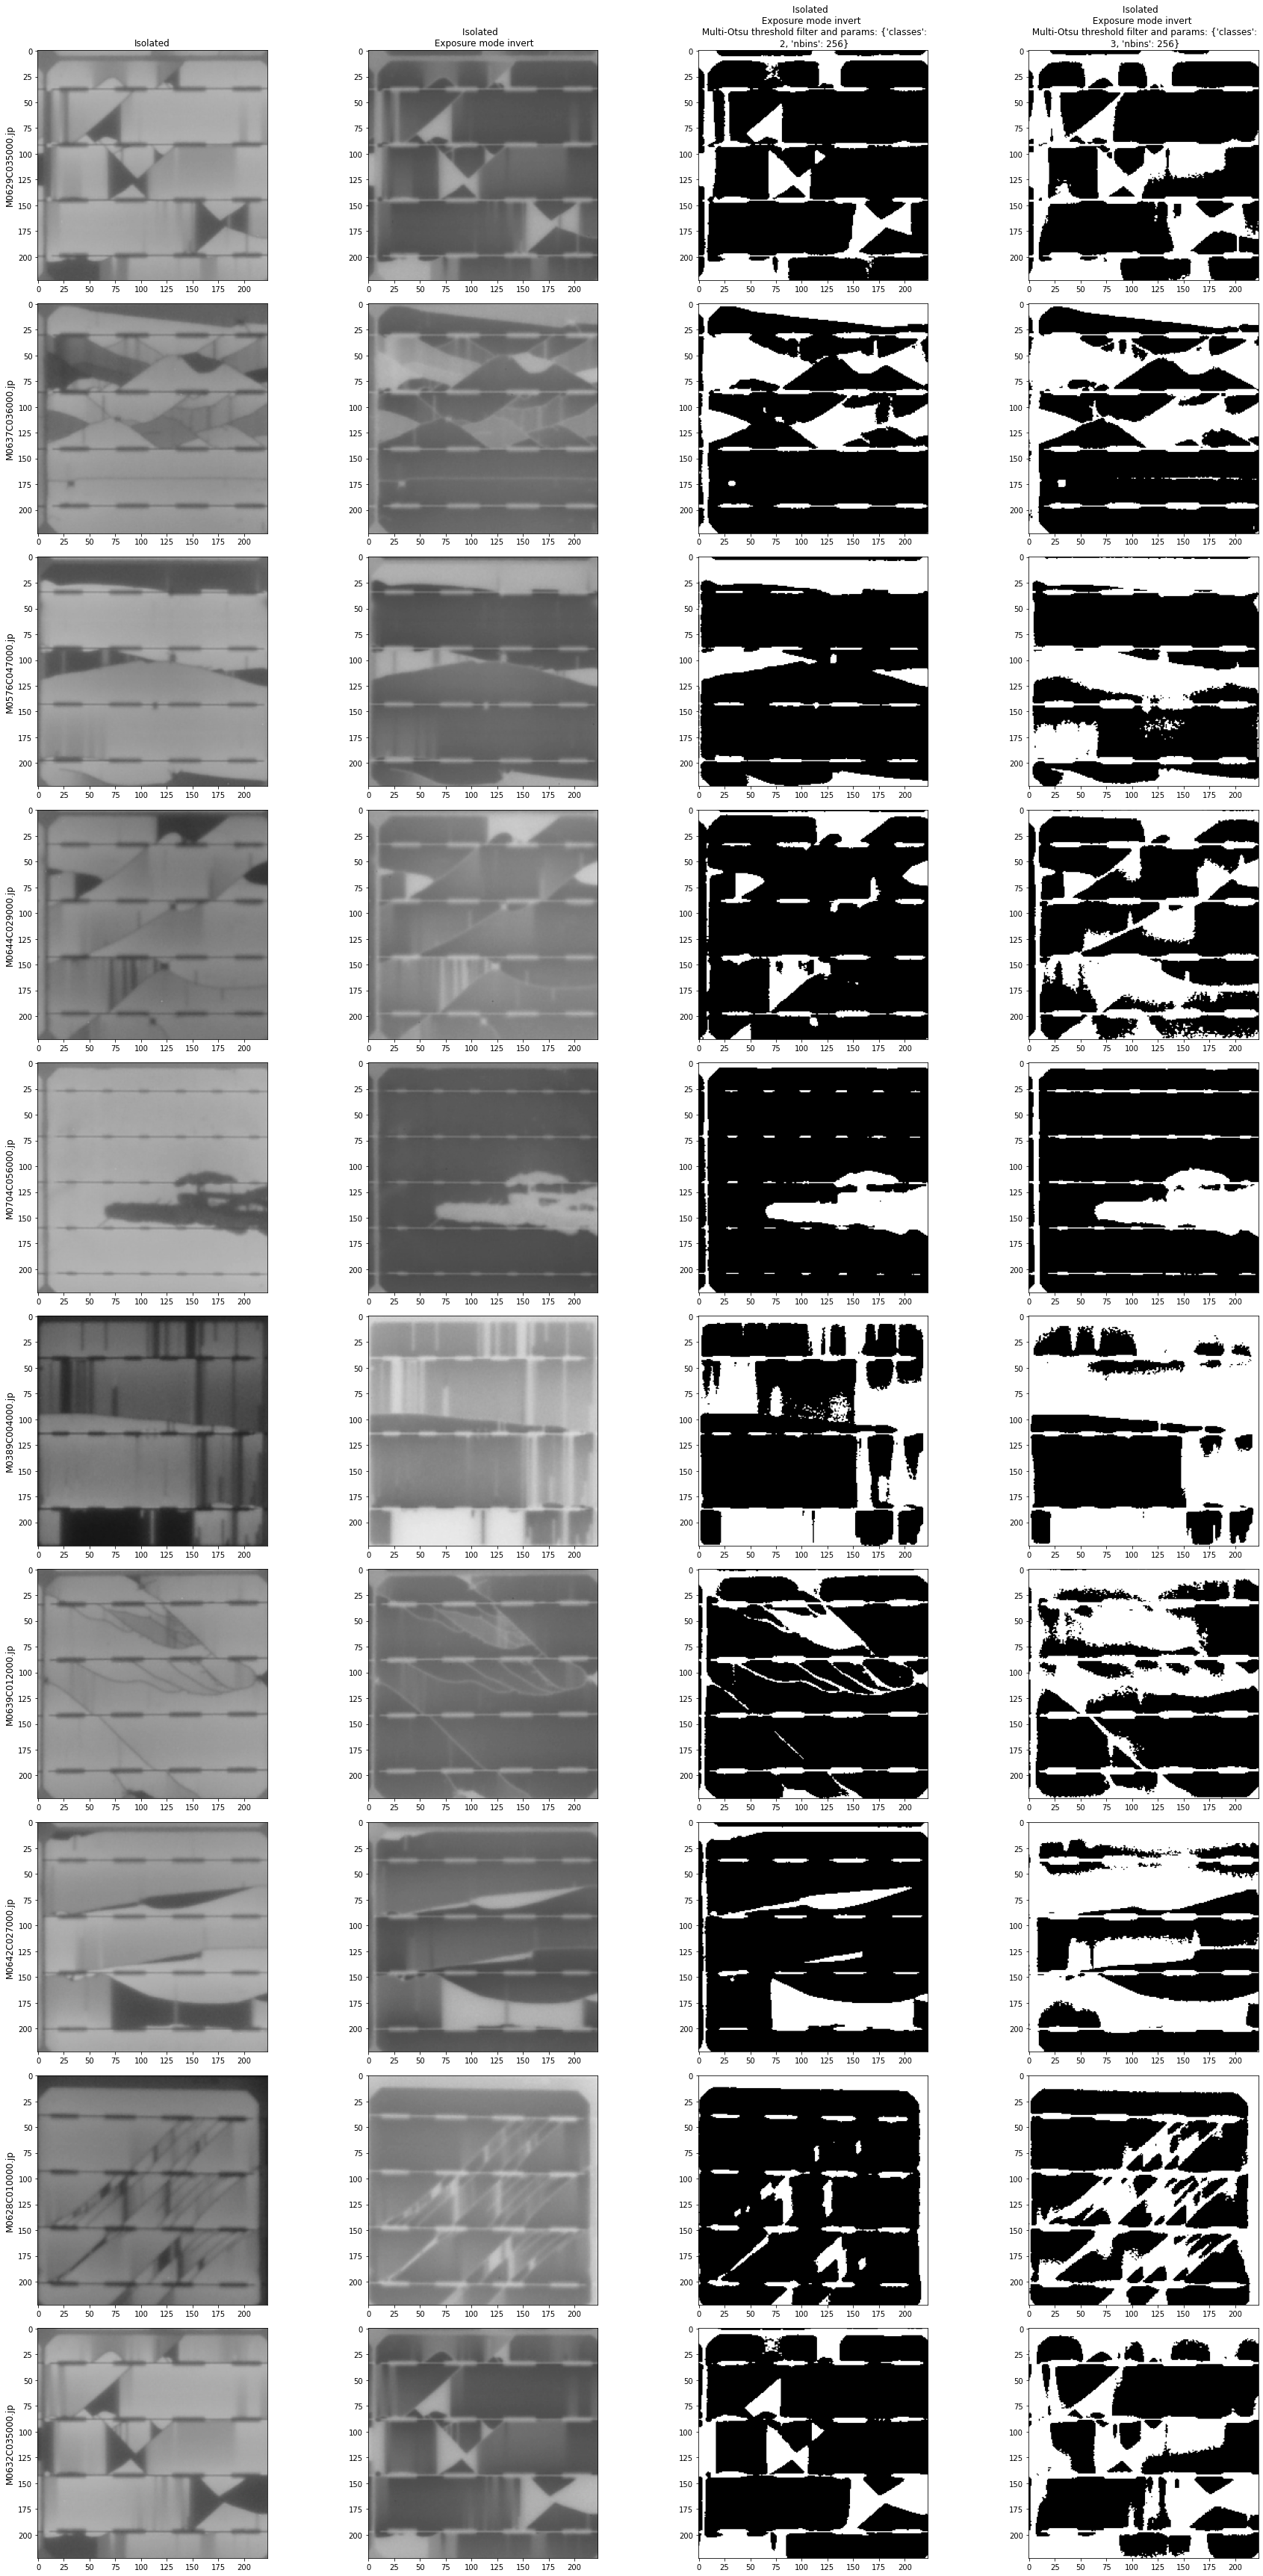

In [18]:
_ = Show(num_images=10, seed=seed) << (original, inverted, thresholded_2, thresholded_3)

# This looks pretty reasonable for only two rather simplistic transforms. Having two threshold levels appears to be the right balance between feature vs noise extraction. 

There are a few issues though:

- The busbar pattern is occasionally picked up during the thresholding. 
- Misaligned border crop regions are also picked up during the thresholding.
- Sometimes cracks and thin diagonal and vertical lines are remaining after thresholding. 

The busbar effect can perhaps be countered by:
- removing the busbars and blurring. 
- Isolating and subtrcting the thresholded busbar pattern and then subtracting this from the thresholded image would remove the pattern where it occurs only. 
- subtracting all non-busbar regions. 
- applying the multi-otsu threshold only to the busbar regions to create a mask.
- subtracting this mask from the thresholded image. 

The cracks and thin diagonal lines can perhaps be addressed by a combination of:

- Blurring the image with a gaussian kernel may help with avoiding the pick up of unwanted high frequency features such as cracks and thin vertical lines. 
- Band pass filtering to remove high frequency information. 
- blob detection and erosion around the detected blobs. 

In [98]:
# Busbar removal

In [171]:
defect = (DefectViewer() << (ImageLoader(defect_class='Isolated') << n_samples))
oriented_defect = Orient(num_jobs=20) << defect
defect.category = 'FrontGridInterruption'

In [180]:
removed = RemoveBusBars() << oriented_defect

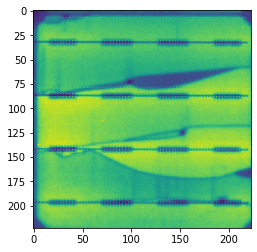

In [181]:
plt.imshow(removed[1].images[0])

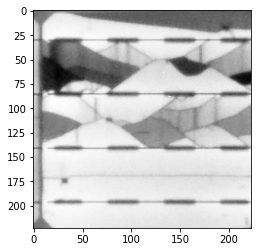

In [102]:
i = 1
test_img = isolated.images[i]
plt.imshow(test_img, cmap='Greys_r')

In [197]:
hog_params = {'pixels_per_cell': (3, 3), 'num_jobs': 2}
hog_img = HOG(**hog_params).apply(isolated.images)

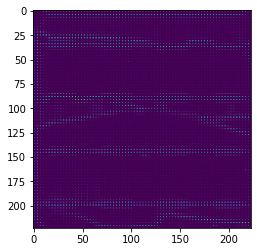

In [478]:
h_img = hog_img[2]
plt.imshow(h_img)

In [513]:
# Exposure stretch the HOG image and apply the sigmoid
hog_stretched = Exposure('stretch').apply(hog_img)

# Mask the HOG and apply the sigmoid
sig_hog = Exposure('sigmoid').apply(hog_stretched)

# Sum the pixel values in the X direction
hog_signal = sig_hog.sum(axis=-1).astype(int)

# These are the minimum counts per row that are acceptable
hog_threshold = (hog_signal.max(axis=-1) / 4)[:, np.newaxis]

# All rows that are greater than the threshold for that image
        # noinspection PyUnresolvedReferences
hog_index = (hog_signal > hog_threshold).astype(int)

# Create row-wise mask
mask = np.repeat(hog_index[:,:,np.newaxis], h_img.shape[1], axis=2)

mask[mask > 0]=1

#Apply buffer
edge_buffer = 10
mask[2, 0:edge_buffer,:] = 0
mask[:,-edge_buffer:,:] = 0

# fill any inbet

In [528]:
hog_threshold[5][0]

12.5

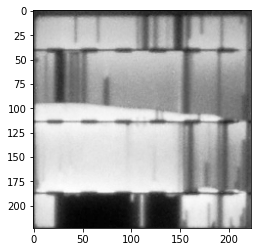

In [521]:
plt.imshow(isolated.images[5], cmap='Greys_r')

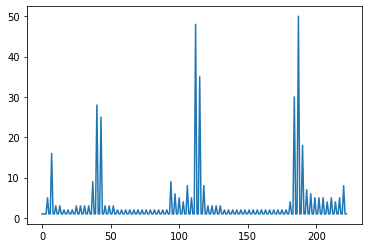

In [517]:
plt.plot(hog_signal[5])

In [518]:
from scipy.signal import find_peaks

In [584]:
sig = hog_signal[5]
found_peaks, _  = find_peaks(sig, height=hog_threshold[5][0], distance = 20)

In [585]:
type(found_peaks)

numpy.ndarray

In [589]:
n = 2
row_coords = []
for i in range(-n, n + 1, 1):
    [row_coords.append(x) for x in found_peaks + i]


In [591]:
np.array(row_coords)

array([  5,  38, 110, 185,   6,  39, 111, 186,   7,  40, 112, 187,   8,
        41, 113, 188,   9,  42, 114, 189])

In [563]:
my_list.remove(0)
my_list

[-3, -2, -1, 1, 2, 3]

In [208]:
shaken_hog = sig_threshold_hog + \
            np.roll(sig_threshold_hog, shift=-1, axis=-1) + np.roll(sig_threshold_hog, shift=1, axis=-1) + \
            np.roll(sig_threshold_hog, shift=-2, axis=-1) + np.roll(sig_threshold_hog, shift=2, axis=-1) + \
            np.roll(sig_threshold_hog, shift=-3, axis=-1) + np.roll(sig_threshold_hog, shift=3, axis=-1) + \
            np.roll(sig_threshold_hog, shift=-4, axis=-1) + np.roll(sig_threshold_hog, shift=4, axis=-1)
shaken_hog = shaken_hog + np.roll(shaken_hog, shift=1, axis=-2) + np.roll(shaken_hog, shift=-1, axis=-2)

In [209]:
final_hog = Exposure('sigmoid', cutoff=0.3).apply(Exposure('stretch').apply(shaken_hog))

In [210]:
in_imgs=test_img
out_img = (1 - final_hog) * in_imgs + final_hog * (
                    np.roll(in_imgs, shift=10, axis=-2) + np.roll(in_imgs, shift=-10, axis=-2)) / 2

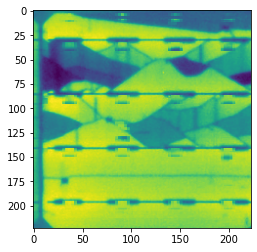

In [211]:
plt.imshow(out_img)

In [29]:
# blob detection
from skimage.feature import blob_dog, blob_log, blob_doh
from skimage.io import imread, imshow
from skimage.color import rgb2gray
from math import sqrt
import matplotlib.pyplot as plt
import numpy as np
from skimage.morphology import erosion, dilation, opening, closing
from skimage.measure import label, regionprops
from skimage.color import label2rgb

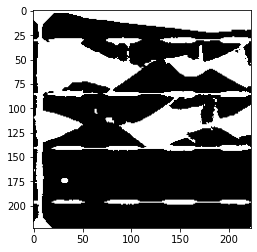

In [71]:
i = 1
test_img = thresholded_2.images[i]
plt.imshow(test_img, cmap='Greys_r')

N blobs found: 0


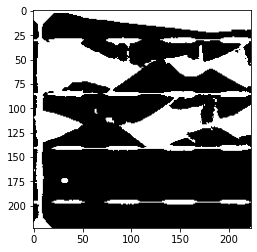

In [92]:
blobs = blob_log(
    test_img, max_sigma=500, num_sigma=1, threshold=.1)

print(f"N blobs found: {len(blobs)}")

fig, ax = plt.subplots()
ax.imshow(test_img, cmap='gray')
for blob in blobs:
    y, x, area = blob
    ax.add_patch(plt.Circle((x, y), area*np.sqrt(2), color='r', 
                            fill=False))

In [96]:
from math import sqrt
from skimage import data
from skimage.feature import blob_dog, blob_log, blob_doh
from skimage.color import rgb2gray

import matplotlib.pyplot as plt


image = data.hubble_deep_field()[0:500, 0:500]
image_gray = rgb2gray(image)

blobs_log = blob_log(image_gray, max_sigma=30, num_sigma=20, threshold=.1)


In [97]:
print(len(blobs_log))

545


20 principal components explain 93.89 % of the total variance


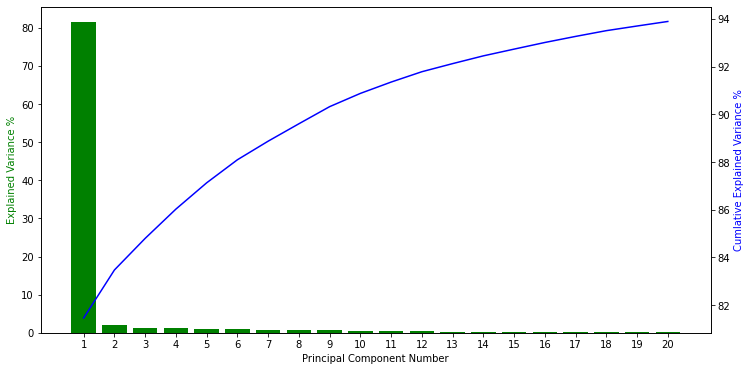

In [10]:
# Instantiate class
n =20
PCA_class_clean = PCA(transpose=True, n_components=n, whiten=True)

# Claculate the transform on the images
PCA_class_clean << clean

# Total explained Variance
exp_var = PCA_class_clean.explained_variance_ratio[0]
total_exp_var = np.sum(exp_var)
print(f'{n} principal components explain {total_exp_var * 100:.2f} % of the total variance')

# Plot 
variance_plot(exp_var, n)

20 principal components explain 98.77 % of the total variance


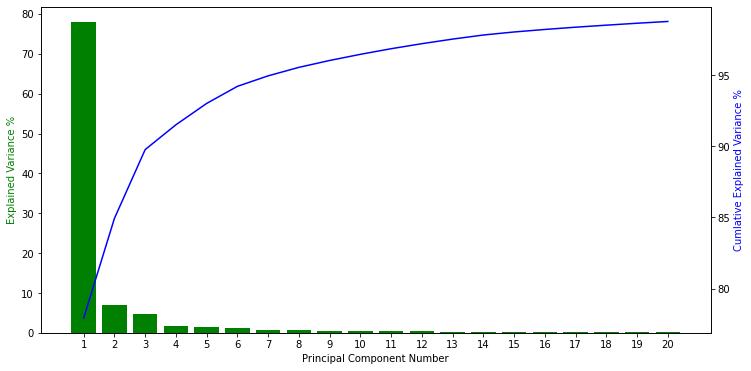

In [11]:
# Instantiate class
n = 20
PCA_class_defect = PCA(transpose=True, n_components=n, whiten=True)

# Claculate the transform on the images
PCA_class_defect << defect

# Total explained Variance
exp_var = PCA_class_defect.explained_variance_ratio[0]
total_exp_var = np.sum(exp_var)
print(f'{n} principal components explain {total_exp_var * 100:.2f} % of the total variance')

# Plot 
variance_plot(exp_var, n)

### Let's view the Eigenfaces of each

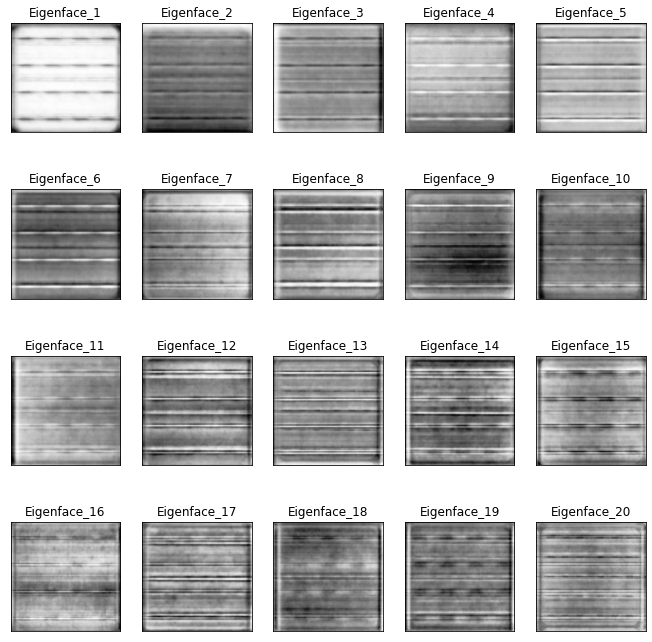

In [12]:
## Clean images
plot_gallery(PCA_class_clean.eigenfaces[0], 224, 224)

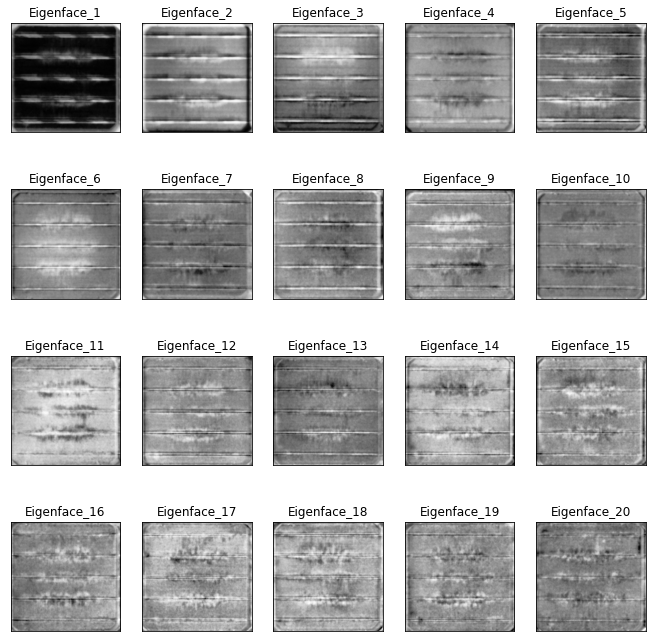

In [13]:
## Defected images
plot_gallery(PCA_class_defect.eigenfaces[0], 224, 224)

## Apply PCA transforms on 500 images

#### Clean images, PCA on 500 stacked images to 2 components

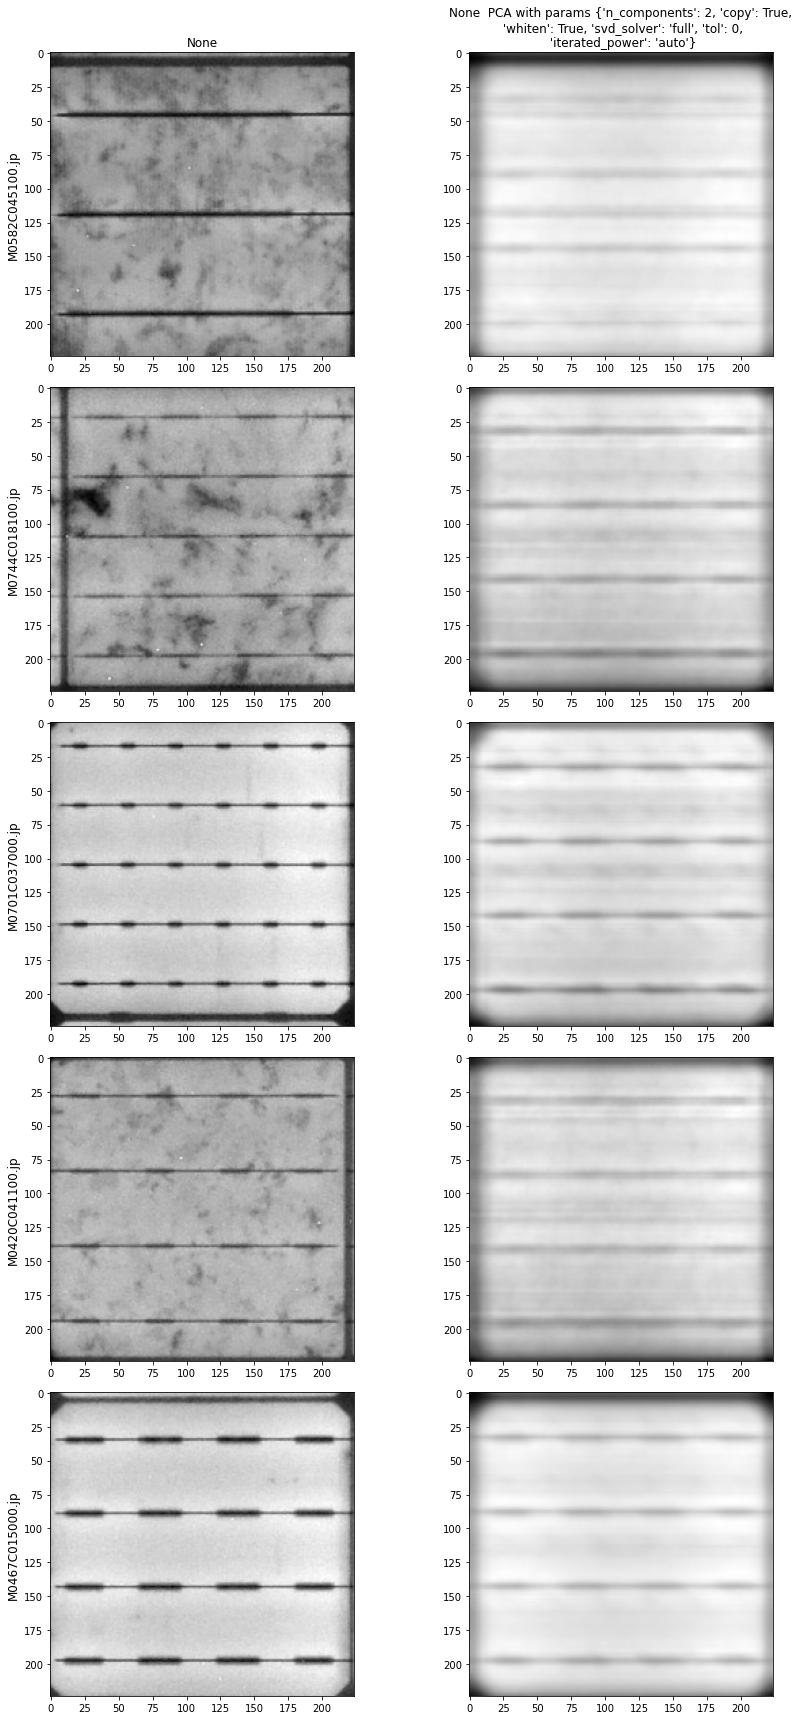

In [20]:
_ = Show(num_images=5, seed=40) << (PCA(transpose=True, n_components = 2, whiten=True) << (clean))

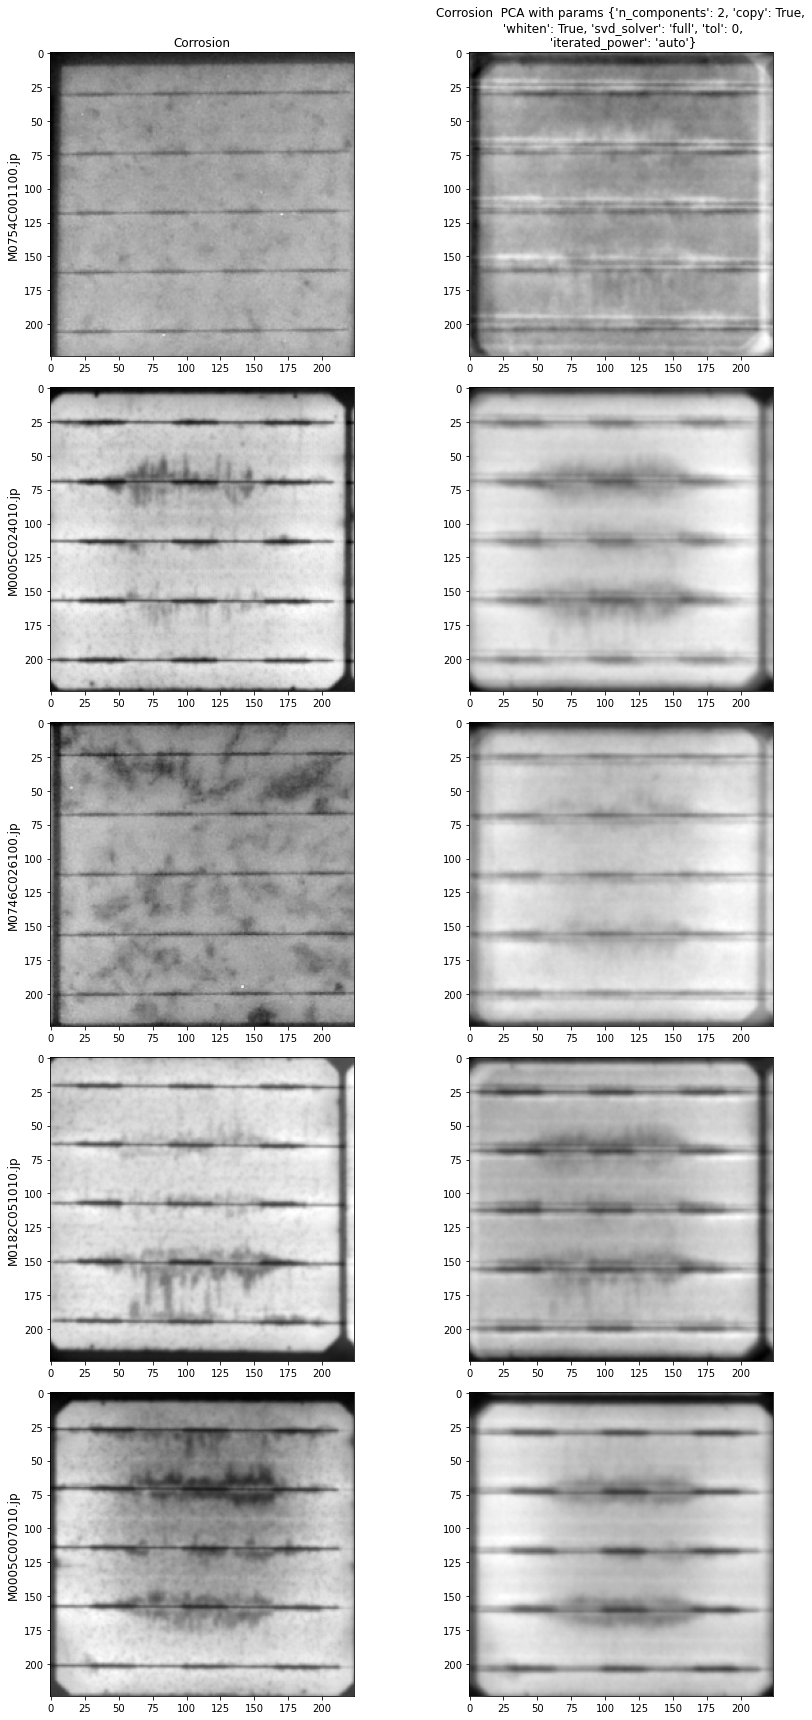

In [21]:
#### Clean images, PCA on 500 stacked images to 6 components
_ = Show(num_images=5, seed=40) << (PCA(transpose=True, n_components = 2, whiten = True) << (defect))

### PCA for segmentation

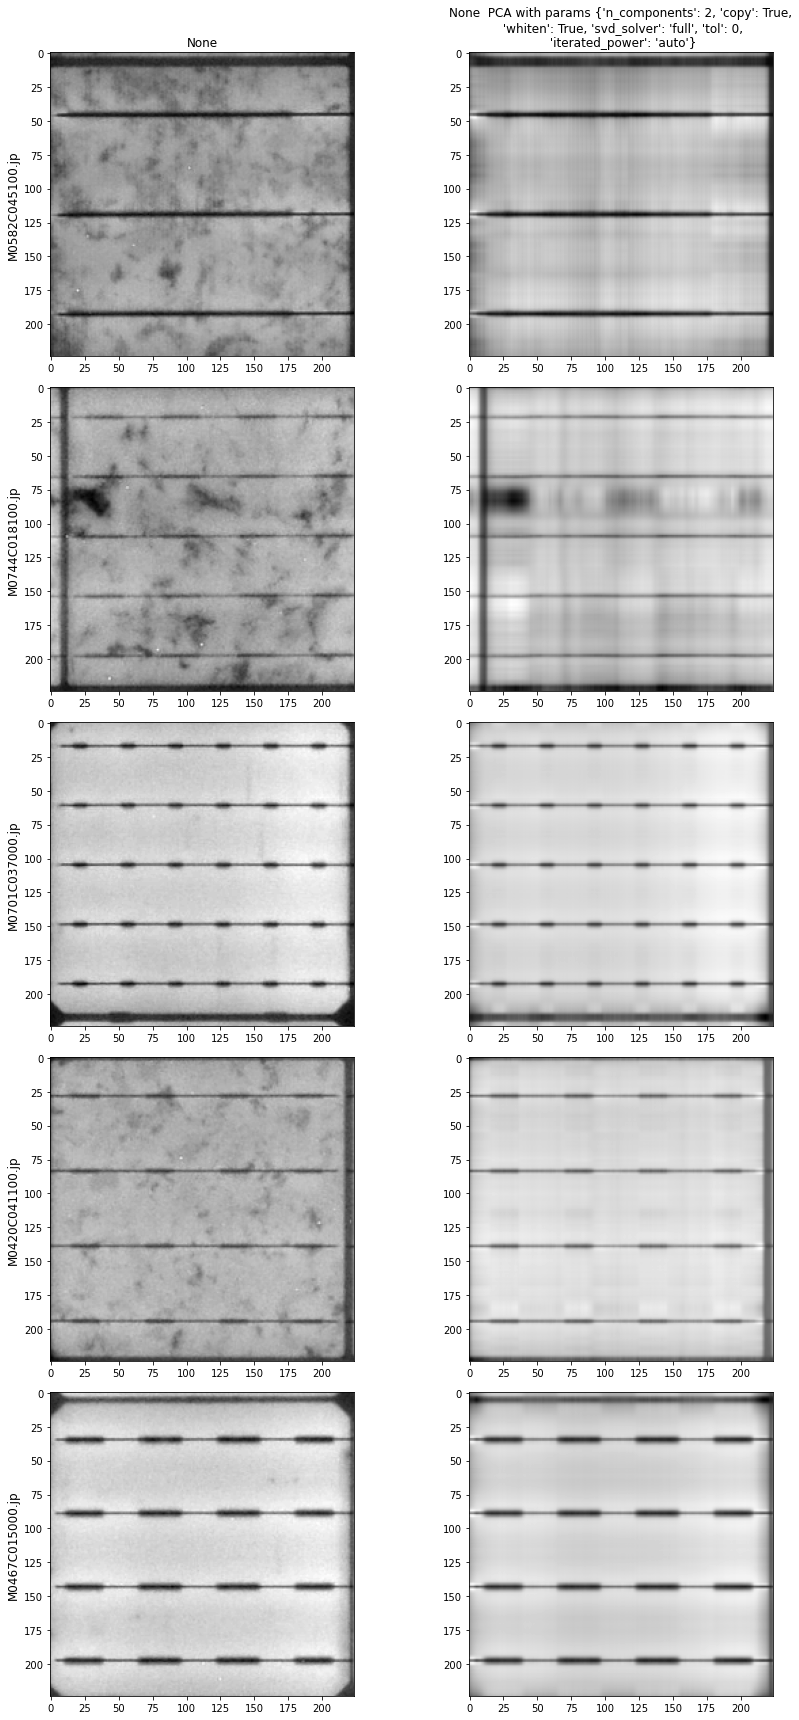

In [26]:
_ = Show(num_images=5, seed=40) << (PCA(transpose=False, n_components = 2, whiten=True) << (clean))

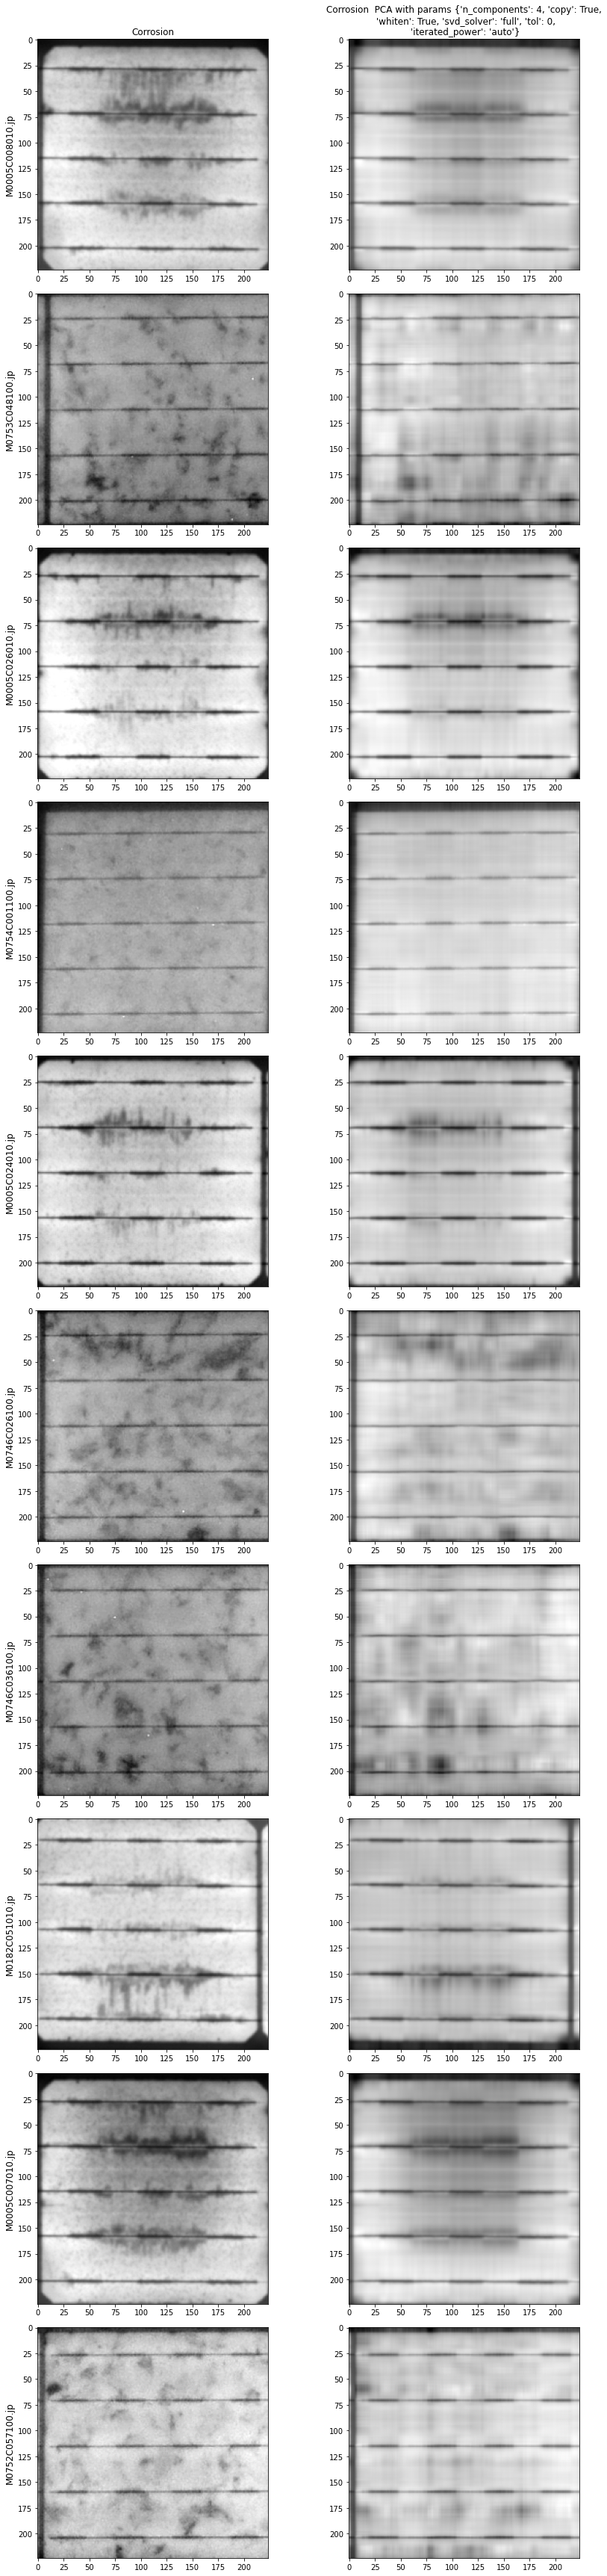

In [28]:
_ = Show(num_images=10, seed=40) << (PCA(transpose=False, n_components = 4, whiten=True) << (defect))